# Importing libraries

In [1]:
#Importing Required libraries
import numpy as np 
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import PIL 
from IPython.display import display,IFrame
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode
np.random.seed(25)

# Imputation by averaging surrounding values

In [2]:
# Imputation
def averaging_nans(data_matrix):
    
    """
    This function performs imputation of NaN values by taking the average of all the immediate non-nan neighbors surrounding pixels in the same image. In case if all neighbours are nans, the value of the pixel is set to 0.
    """
    def pixel_average(data_matrix, i, j):
        l = []
        for c1 in range(3):
            for c2 in range(3):
                
                if (0<i-1+c1 < len(data_matrix) and 0<j-1+c2<len(data_matrix[0])):
                    if not np.isnan(data_matrix[i-1+c1][j-1+c2]):
                        l.append(data_matrix[i-1+c1][j-1+c2])
        if len(l)>0:
            return np.mean(l)
        else:
            return 0.0

        
    for i in range(len(data_matrix)):
        for j in range(len(data_matrix[i])):
            if np.isnan(data_matrix[i][j]):
                data_matrix[i][j] = pixel_average(data_matrix,i,j)
            
    
    return data_matrix

# Loading Training and Test Data and Performing Imputation

In [3]:
##Change this code to make it work it in Jupyter
N_TRAIN = 10000
dim = 28
data_original = np.zeros((dim,dim,N_TRAIN))
labels = np.zeros((N_TRAIN,1))

data_flattened = np.zeros((N_TRAIN,dim**2))
im = 0

# Importing from kaggle
for dirname, _, filenames in os.walk('/kaggle/input/iitmee4708/'):
    for filename in filenames:
        
        if filename == "public_test.csv":
            test_data = np.loadtxt(open(os.path.join(dirname, filename), "rb"), delimiter=",")
        else:
            if filename =="SVM_rbfC1000_pred.csv":
                break
            # imputing nans and storing the images in the appropriate position in the matrix
            data_original[:,:,im] = averaging_nans((np.loadtxt(open(os.path.join(dirname, filename), "rb"), delimiter=",")))
            
            labels[im] = dirname[-1]   
            # 28x28 data is flattened to 784 data point
            data_flattened[im,:] = data_original[:,:,im].T.reshape(1,dim**2)
            im += 1        
            
labels = labels.astype(int)

# Addition of small Gaussian Noise and Normalization

In [4]:
# Normalize the data
X = (data_flattened.copy())/255.0
y = labels.copy()
X_test = test_data.copy()/255.0
X_test = np.transpose(X_test)

# Adding white noise to create another dataset
X_noise = data_flattened + np.random.normal(0,1e-4,(data_flattened.shape[0],data_flattened.shape[1]))
X_noise /= 255

# Joining the given dataset and noisy dataset
X = np.append(X,X_noise,axis=0)
y = np.append(y,y,axis = 0)
X.shape, y.shape

((20000, 784), (20000, 1))

# Shuffling the training data

In [5]:
# Suffling the dataset to remove class bias during the traininig
X_y = np.append(X,y,axis = 1)
np.random.shuffle(X_y)
X = X_y[:,:-1]
y = X_y[:,-1]

# Training Data Visualization

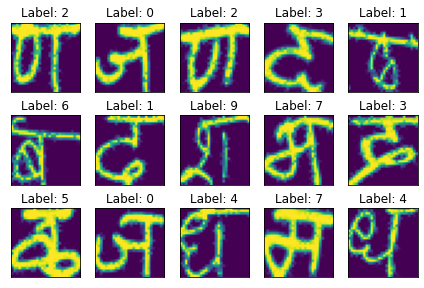

In [6]:
ind_display = np.random.randint(0,N_TRAIN,15)
fig,ax = plt.subplots(3,5)
for ind in range(len(ind_display)):       
    ax[ind//5,ind%5].imshow(PIL.Image.fromarray(X_noise[ind_display[ind],:].reshape(dim,dim).T*255).convert("L"))
    ax[ind//5,ind%5].set_xticks([])
    ax[ind//5,ind%5].set_yticks([])
    ax[ind//5,ind%5].set_title("Label: "+str(labels[ind_display[ind]][0]))
fig.tight_layout(pad=1)

# Dimensionality reduction using PCA

In [7]:
pca = PCA(n_components=45)
pca.fit(X)
X_1 = pca.fit_transform(X)

# Ensembling with SVM - RBF Kernel

In [8]:
from tqdm import tqdm
def bagging_SVM_rbf_same(sample_size,X,y):
    models = []
    
    for i in tqdm(range(200)):        
        ## Bootstrap samples
        ind = np.random.choice(np.arange(X.shape[0]),sample_size,replace = False)  
        X_sample = X[ind]
        y_sample = y[ind]            
        #Train-validation Split
        Xs_train,Xs_val,ys_train,ys_val = train_test_split(X_sample,y_sample,test_size  = 1000/sample_size)
        #SVC Model - RBF Kernel with regularization parameter C = 1000
        svm_model = SVC(kernel = "rbf",C = 1000)
        svm_model.fit(Xs_train,ys_train.ravel())
        train_acc = svm_model.score(Xs_train,ys_train)
        #Only store model if training accuracy is greater than 90%
        if train_acc>0.9:
            val_acc = svm_model.score(Xs_val,ys_val)
            models.append((svm_model,(train_acc,val_acc)))
        
    return models

In [1]:
bagging_ensemble_rbf_same_new = bagging_SVM_rbf_same(20000,X_1,y)

# Evaluating all models on the test data and taking the mode (consensus prediction)

In [10]:
y_mat_comb = np.zeros((1000,1))
#PCA transformation of Test Data
X_test_pca = pca.transform(X_test)

for model in bagging_ensemble_rbf_same_new:
    y_mat_comb = np.append(y_mat_comb,model[0].predict(X_test_pca).reshape(-1,1),axis = 1)        
    
y_mat_comb = y_mat_comb[:,1:]
y_test_pred = mode(y_mat_comb,axis = 1)[0].astype(int).ravel()


(1000, 15)

# Saving the models

In [11]:
import csv
l = [['Id', 'Expected']]

with open("SVM_ENSEMBLE_RBF1000_2X_Norm_NOISE.csv",'w') as f:
    w = csv.writer(f)
    w.writerow(l[0])
    for i in range(1000):
        l.append(['Sample_'+str(i+1), y_test_pred[i]])
        w.writerow(['Sample_'+str(i+1), y_test_pred[i]])
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'SVM_ENSEMBLE_RBF1000_2X_Norm_NOISE.csv')

/kaggle/working/SVM_ENSEMBLE_RBF1000_2X_Norm_NOISE.csv

In [12]:
import pickle
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
final_model = [pca,bagging_ensemble_rbf_same_new]
with open('SVM_ENSEMBLE_RBF1000_2X_Norm_NOISE.pkl', 'wb') as f:
    pickle.dump(final_model, f)
FileLink(r'./SVM_ENSEMBLE_RBF1000_2X_Norm_NOISE.pkl')

/kaggle/working/SVM_ENSEMBLE_RBF1000_2X_Norm_NOISE.pkl

# Function to load model and predict on the given test datasets

In [28]:

def predict_private_dataset():
    
    # Data Pre-processing
    test_data = np.loadtxt(open('public_test.csv', "rb"), delimiter=",")
    test_data = test_data.copy()/255.0
    test_data = np.transpose(test_data)
    
    # Loading the models
    pca, ensemble_svm = pickle.load(open('SVM_ENSEMBLE_RBF1000.pkl', 'rb'))
    y_mat_comb = np.zeros((len(test_data),1))
    
    #PCA transformation of Test Data
    X_test_pca = pca.transform(test_data)
#     for model in ensemble_svm:
    for i in range(10):
#         y_mat_comb = np.append(y_mat_comb,model[0].predict(X_test_pca).reshape(-1,1),axis = 1) # Predict from each model
        y_mat_comb = np.append(y_mat_comb,ensemble_svm[i][0].predict(X_test_pca).reshape(-1,1),axis = 1)
    
    y_mat_comb = y_mat_comb[:,1:]
    
    # Taking the consensus
    y_test_pred = mode(y_mat_comb,axis = 1)[0].astype(int).ravel()
    
    predicted_class = y_test_pred.reshape(-1,1);
    
    return predicted_class

# predict_private_dataset()

In [29]:
public_pred = predict_private_dataset()

from sklearn.metrics import f1_score
from numpy import genfromtxt
my_data = genfromtxt('public_test_labels.csv', delimiter=',')
f1_score(my_data, public_pred, average='macro')

C:\Users\prash\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\prash\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


0.9799774747282678

In [23]:
pickle.load(open('SVM_ENSEMBLE_RBF1000.pkl', 'rb'))

AttributeError: Can't get attribute 'bagging_SVM_rbf_same' on <module '__main__'>